<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
push!(LOAD_PATH, ".")
using RobustOptimization
using Ipopt, JuMP, PyPlot
using ScikitLearn
@sk_import model_selection: train_test_split
@sk_import metrics: roc_curve
@sk_import metrics: roc_auc_score
@sk_import metrics: accuracy_score
@sk_import metrics: classification_report
path_train = "datasets/ionosphere_scale"
nbfeatures = 34
data_train = read_data_libsvm(path_train, nbfeatures);
# xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.15)
# ab_train = hcat(xtr, ytr)
# aux_train = ab_train[ab_train[:,end] .< 0,:]
# ll_train = vcat(aux_train,data_train[data_train[:,end].>0,:])

In [8]:
xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.6)
df_train = hcat(xtr, ytr)
low_train = hcat(xtr, ytr)
df_aux= hcat(xte, yte);
rate = 0.035
sx = rate*size(low_train[low_train[:, end] .> 0, :])[1]/(size(low_train[low_train[:, end] .< 0, :])[1]*(1-rate))
low_data = low_train[low_train[:, end] .< 0, :]
xltr, xlte, yltr, ylte = train_test_split(low_data[:,1:end-1], low_data[:,end], train_size = sx)
low_low = hcat(xltr, yltr)
df_train = vcat(low_low,low_train[low_train[:, end] .> 0, :]);
println(size(low_train[low_train[:, end] .< 0, :])[1]/size(low_train)[1])
println(size(df_train[df_train[:, end] .< 0, :])[1]/size(df_train)[1])
println(size(df_aux[df_aux[:, end] .< 0, :])[1]/size(df_aux)[1])
println(size(low_train[low_train[:, end] .> 0, :])[1]/size(low_train)[1])
println(size(df_train[df_train[:, end] .> 0, :])[1]/size(df_train)[1])
println(size(df_aux[df_aux[:, end] .> 0, :])[1]/size(df_aux)[1])

0.3523809523809524
0.02857142857142857
0.36879432624113473
0.6476190476190476
0.9714285714285714
0.6312056737588653


In [ ]:
# df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.2, train_test_split)
solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
ϵ = 0.05
verbosity = 50
itmax = 2000
sample = 100

ambiguity = "KLdivergence"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# α = 0.1
projParams = ProjParams(Int(40), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [6]:
# Séparer à la main entre label 1 et 0 et regarder les fréquences de chacun
# Fraude bancaire avec faux positifs
# Avec erreur de 0.01% changer le label. Mislabelled training dataset (regarder papier sur le sujet)

In [7]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



([0.0, 0.254545, 0.290909, 0.327273, 0.327273, 0.381818, 0.381818, 0.4, 0.4, 0.454545  …  0.509091, 0.527273, 0.527273, 0.545455, 0.545455, 0.563636, 0.563636, 0.672727, 0.672727, 1.0], [0.0, 0.0, 0.0232558, 0.0232558, 0.0348837, 0.0348837, 0.0697674, 0.0697674, 0.104651, 0.104651  …  0.895349, 0.895349, 0.918605, 0.918605, 0.976744, 0.976744, 0.988372, 0.988372, 1.0, 1.0], [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999972, 0.99959, 4.7961e-32])

In [3]:
e_tab = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.05,0.1,0.5,1.0]

14-element Array{Float64,1}:
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01 
 0.05 
 0.1  
 0.5  
 1.0  

In [9]:
dm_tab = []
xr1_tab = []
xr2_tab = []
fpr1_tab = []
tpr1_tab = []
fpr2_tab = []
tpr2_tab = []
for ϵ in [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.05,0.1,0.5,1.0]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = initialize(df_train, robustModel, KLConstraint())
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_tab, dm)
    push!(xr1_tab, xrobust1)
    push!(xr2_tab, xrobust2)
    push!(fpr1_tab, fpr1)
    push!(tpr1_tab, tpr1)
    push!(fpr2_tab, fpr2)
    push!(tpr2_tab, tpr2)
end

 
espilon = 0.001
 
50 0.0008556000889513582 100 6.926972142706767e-5 150 5.241150837714814e-5 200 0.0007184459188974701 250 0.0011271883420169437 300 0.0007715004669245629 350 0.0007014476349463672 400 0.0010460479806198297 450 0.0006866217193259305 500 0.0006089370822208173 550 0.0009192668248250713 600 0.0007345420610780085 650 0.0006099072287696905 700 0.000761173869578885 750 0.0006017179971826297 800 0.000588175703221866 850 0.0007452764516285224 900 0.0006406651678585451 950 0.0006291528525224493 1000 0.0009202897516224565 1050 0.00042419470184459906 1100 0.0007045388739464649 1150 0.0005523402082238116 1200 0.0004657225712183244 1250 0.0004528812838974997 1300 0.0006536775288707199 1350 3.9011492782388066e-5 1400 5.631202037966344e-5 1450 4.525914825023389e-5 1500 4.7355142528409874e-5 1550 7.683902750265596e-5 1600 7.238855187645561e-5 1650 9.150148345196771e-5 1700 7.644100816203594e-5 1750 0.00010410492781738005 1800 0.00012256596692968068 1850 0.0001955553004923307 1900 0.0

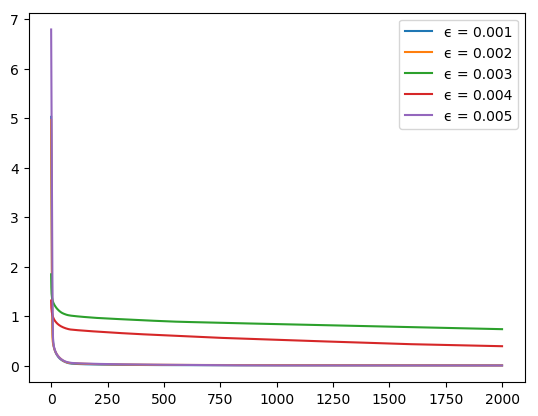

PyObject <matplotlib.legend.Legend object at 0x7f9e4d8f87f0>

In [10]:
for i in 1:5
     plot(dm_tab[i], label="ϵ = $(e_tab[i])")
end
legend()

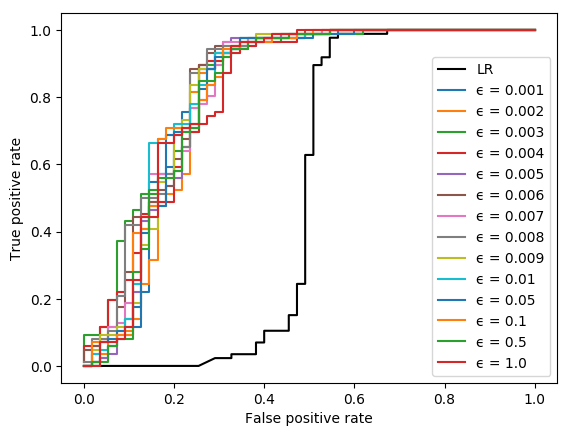

PyObject <matplotlib.legend.Legend object at 0x7f537d787e80>

In [4]:
plot(fpr,tpr, color="black", label="LR")
for i in 1:14
     plot(fpr1_tab[i], tpr1_tab[i], label="ϵ = $(e_tab[i])")
end
xlabel("False positive rate")
ylabel("True positive rate")
legend()

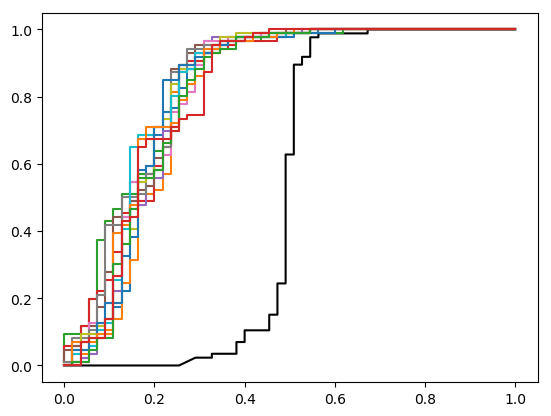

In [12]:
plot(fpr,tpr, color="black")
for i in 1:14
     plot(fpr2_tab[i], tpr2_tab[i])
end

In [13]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:14
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_tab[i], LogisticRegression())))
end

0.5145877378435518  0.7163120567375887
0.8158562367864695  0.6950354609929078
0.804016913319239  0.6879432624113475
0.8399577167019028  0.6879432624113475
0.8243128964059196  0.6950354609929078
0.814799154334038  0.6950354609929078
0.8340380549682875  0.6737588652482269
0.8209302325581396  0.6879432624113475
0.835306553911205  0.6879432624113475
0.8228329809725159  0.6950354609929078
0.8276955602536997  0.7021276595744681
0.8152219873150106  0.6950354609929078
0.8243128964059196  0.7021276595744681
0.8124735729386892  0.6950354609929078
0.8145877378435519  0.7021276595744681


In [14]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:14
    print(roc_auc_score(df_aux[:,end], positive_rate(xr2_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr2_tab[i], LogisticRegression())))
end

0.5145877378435518  0.7163120567375887
0.8158562367864695  0.6950354609929078
0.804016913319239  0.6879432624113475
0.8399577167019028  0.6879432624113475
0.8243128964059196  0.6950354609929078
0.814799154334038  0.6950354609929078
0.8340380549682875  0.6737588652482269
0.8202959830866808  0.6879432624113475
0.835306553911205  0.6879432624113475
0.8228329809725159  0.6950354609929078
0.8289640591966173  0.7021276595744681
0.8226215644820296  0.6879432624113475
0.8245243128964059  0.7021276595744681
0.8099365750528541  0.6950354609929078
0.8143763213530655  0.7021276595744681


In [15]:
# @everywhere df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.7, train_test_split)
# @everywhere solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
# @everywhere ϵ = 0.05
verbosity = 1
itmax = 500
sample = 128

ambiguity = "wasserstein"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# @everywhere α = 1.0
projParams = ProjParams(Int(1000), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [16]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))

([0.0, 0.254545, 0.290909, 0.327273, 0.327273, 0.381818, 0.381818, 0.4, 0.4, 0.454545  …  0.509091, 0.527273, 0.527273, 0.545455, 0.545455, 0.563636, 0.563636, 0.672727, 0.672727, 1.0], [0.0, 0.0, 0.0232558, 0.0232558, 0.0348837, 0.0348837, 0.0697674, 0.0697674, 0.104651, 0.104651  …  0.895349, 0.895349, 0.918605, 0.918605, 0.976744, 0.976744, 0.988372, 0.988372, 1.0, 1.0], [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999972, 0.99959, 4.7961e-32])

In [5]:
e_tab = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,
        0.05,0.06,0.07,0.08,0.09,0.1,0.5,1.0]

21-element Array{Float64,1}:
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01 
 0.02 
 0.03 
 0.04 
 0.05 
 0.06 
 0.07 
 0.08 
 0.09 
 0.1  
 0.5  
 1.0  

In [18]:
dm_was = []
xr1_was = []
xr2_was = []
fpr1_was = []
tpr1_was = []
fpr2_was = []
tpr2_was = []
for ϵ in [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,
        0.05,0.06,0.07,0.08,0.09,0.1,0.5,1.0]
# for ϵ in [0.001,0.005,0.01]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = init_proj(df_train, robustModel, projParams);
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_was, dm)
    push!(xr1_was, xrobust1)
    push!(xr2_was, xrobust2)
    push!(fpr1_was, fpr1)
    push!(tpr1_was, tpr1)
    push!(fpr2_was, fpr2)
    push!(tpr2_was, tpr2)
end

 
espilon = 0.001
 
1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 2.1580793250746007e-7 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 8.572540418846919e-9 61 0.0 62 0.0 63 0.0 64 0.0 65 3.5574601552450236e-6 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 1.2638249313296716e-6 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 1.3572656947999362e-9 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 9.082182778410997e-9 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 3.5820611413291082e-6 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 4.01501748514832e-15 75 0.0 76 0.0 77 3.588817611144268e-15 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 4.021231732133368e-6 107 0.0 108 0.0 109 0.0 110 0.0 111 7.978096447831123e-6 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 6.304324540738412e-6 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 2.1307998752592705e-6 56 0.0 57 0.0 58 1.1985181514080623e-6 59 0.0 60 5.7618705541915476e-6 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 3.022050352271058e-6 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 5.345425563206552e-6 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0 126 0.0 127 0.0 128 

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 5.628947467254536e-6 58 0.0 59 0.0 60 7.739193393205626e-6 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 2.39465169152471e-6 97 2.143221573095832e-6 98 0.0 99 0.0 100 0.0 101 0.0 102 9.456203448467084e-6 103 0.0 104 6.036916953154527e-7 105 0.0 106 0.0 107 0.0 108 0.0 109 1.1539935933918555e-10 110 0.0 111 0.0 112 3.0023276753332606e-6 113 0.0 114 0.0 115 6.5985231484776835e-6 116 0.0 117 0.0 118 0.0 119 0.0 

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 4.725370466474466e-7 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 4.8748181269431257e-8 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 1.6501557065229377e-16 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 5.707342763206034e-6 100 0.0 101 8.480480061427405e-6 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 1.4616346327711582e-14 110 0.0 111 6.236499514896202e-6 112 0.0 113 0.0 114 6.067476851542852e-6 115 0.0 116 0.0 117 0.0 118 0.0 119 9.373819049326645e-

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 3.838160446533595e-6 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 6.465285034770729e-11 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 8.598065783075454e-6 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 1.5248219353836134e-15 124 0.0 125 0.0 126 0.0 127 0.0 128 6.017696021136973

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 5.16739439257452e-6 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0 126 1.2102504515698262e-7 127 4.458099728131681e-6 128 0.0 129 0.0 130 0.0 131 0.0 132 0.0 1

1 0.0 2 0.0 3 0.0 4 1.9502645508956418e-8 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 5.586763134766883e-7 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 4.639131310005262e-12 86 0.0 87 8.688877794246763e-6 88 0.0 89 0.0 90 0.0 91 0.0 92 1.3574211199518516e-15 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 9.503627922907362e-6 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 4.67717926236344e-6 121 2.920785481178868e-6 1

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0 126 0.0 127 0.0 128 0.0 129 0.0 130 0.0 131 0.0 132 0.0 133 0.0 134 0.0 135 0.0 136 0.0 137 0.0 138 0.0 139 

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 4.5082512278860065e-7 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 6.577005178831988e-6 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 0.0 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 8.902054212694965e-6 88 4.1122270519333703e-14 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 0.0 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 0.0 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 4.1063780388365945e-6 123 0.0 124 0.0 125 0.0 126 0.0 127 0.0 128

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 7.310171694481504e-6 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 28 0.0 29 0.0 30 0.0 31 0.0 32 0.0 33 0.0 34 0.0 35 0.0 36 0.0 37 0.0 38 0.0 39 0.0 40 0.0 41 0.0 42 0.0 43 0.0 44 0.0 45 0.0 46 0.0 47 0.0 48 0.0 49 0.0 50 0.0 51 0.0 52 0.0 53 0.0 54 0.0 55 0.0 56 0.0 57 3.5327124652800163e-6 58 0.0 59 0.0 60 0.0 61 0.0 62 0.0 63 0.0 64 0.0 65 0.0 66 0.0 67 0.0 68 0.0 69 0.0 70 0.0 71 0.0 72 0.0 73 0.0 74 0.0 75 0.0 76 0.0 77 0.0 78 0.0 79 0.0 80 0.0 81 0.0 82 0.0 83 0.0 84 0.0 85 0.0 86 0.0 87 0.0 88 0.0 89 0.0 90 0.0 91 0.0 92 0.0 93 0.0 94 3.850690382552571e-6 95 0.0 96 0.0 97 0.0 98 0.0 99 0.0 100 0.0 101 0.0 102 5.070111149192745e-6 103 0.0 104 0.0 105 0.0 106 0.0 107 0.0 108 0.0 109 0.0 110 4.3745291466789976e-6 111 0.0 112 0.0 113 0.0 114 0.0 115 0.0 116 0.0 117 0.0 118 0.0 119 0.0 120 0.0 121 0.0 122 0.0 123 0.0 124 0.0 125 0.0 126 0.0 127 0.0 128 0

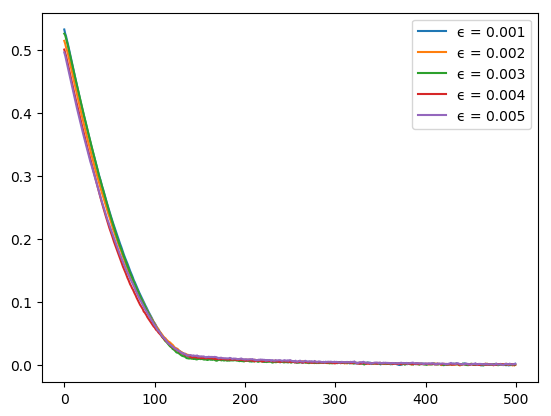

PyObject <matplotlib.legend.Legend object at 0x7f9e4d694390>

In [19]:
for i in 1:5
     plot(dm_was[i], label="ϵ = $(e_tab[i])")
end
legend()

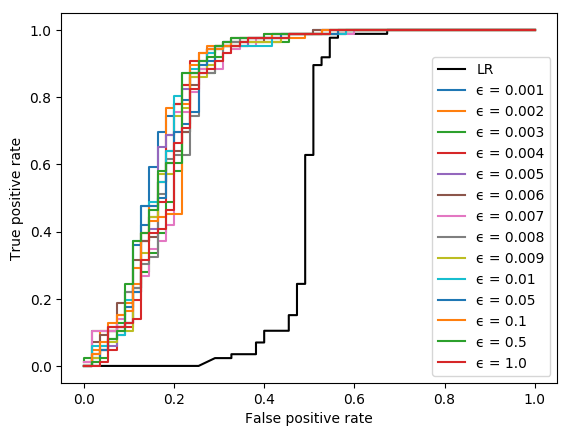

PyObject <matplotlib.legend.Legend object at 0x7f5377e89588>

In [6]:
plot(fpr,tpr, color="black", label="LR")
for i in [1,2,3,4,5,6,7,8,9,10,14,19,20,21]
     plot(fpr1_was[i], tpr1_was[i], label="ϵ = $(e_tab[i])")
end
xlabel("False positive rate")
ylabel("True positive rate")
legend()

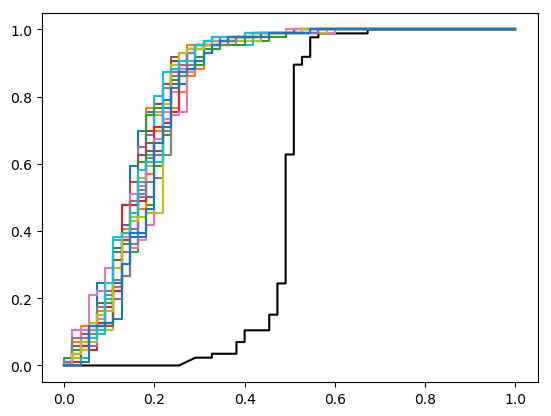

In [21]:
plot(fpr,tpr, color="black")
for i in 1:21
     plot(fpr2_was[i], tpr2_was[i])
end

In [22]:
# Montrer pour différente de taille de dataset et regarder à partir de quel moment la méthode de base décroche

In [23]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:21
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_was[i], LogisticRegression())))
end

0.5145877378435518  0.7163120567375887
0.8403805496828752  0.6950354609929078
0.8346723044397464  0.6950354609929078
0.8141649048625792  0.6879432624113475
0.8298097251585623  0.6950354609929078
0.8291754756871036  0.6879432624113475
0.8293868921775899  0.6879432624113475
0.8154334038054969  0.6879432624113475
0.8154334038054969  0.6879432624113475
0.8217758985200846  0.6808510638297872
0.8353065539112051  0.7021276595744681
0.818816067653277  0.6879432624113475
0.8268498942917548  0.6879432624113475
0.8287526427061311  0.6950354609929078
0.8257928118393234  0.6879432624113475
0.8243128964059196  0.6879432624113475
0.8361522198731501  0.6950354609929078
0.8304439746300212  0.6879432624113475
0.8224101479915433  0.6950354609929078
0.8230443974630021  0.6879432624113475
0.8325581395348838  0.6879432624113475
0.811416490486258  0.6737588652482269


In [24]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:21
    print(roc_auc_score(df_aux[:,end], positive_rate(xr2_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr2_was[i], LogisticRegression())))
end

0.5145877378435518  0.7163120567375887
0.8403805496828753  0.6950354609929078
0.8346723044397464  0.6950354609929078
0.8133192389006342  0.6808510638297872
0.8298097251585623  0.6950354609929078
0.8289640591966174  0.6879432624113475
0.8295983086680762  0.6879432624113475
0.8152219873150106  0.6879432624113475
0.8162790697674418  0.6879432624113475
0.822198731501057  0.6808510638297872
0.835306553911205  0.7021276595744681
0.818816067653277  0.6879432624113475
0.8268498942917548  0.6879432624113475
0.8289640591966174  0.6950354609929078
0.826215644820296  0.6879432624113475
0.8243128964059196  0.6879432624113475
0.8361522198731501  0.6950354609929078
0.8306553911205073  0.6879432624113475
0.8226215644820296  0.6950354609929078
0.8230443974630021  0.6879432624113475
0.8323467230443975  0.6879432624113475
0.8109936575052854  0.6737588652482269


In [25]:
println(classification_report(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
println(classification_report(df_aux[:,end], pred(df_aux, xr1_was[3], LogisticRegression())))

             precision    recall  f1-score   support

       -1.0       1.00      0.27      0.43        55
        1.0       0.68      1.00      0.81        86

avg / total       0.81      0.72      0.66       141

             precision    recall  f1-score   support

       -1.0       1.00      0.20      0.33        55
        1.0       0.66      1.00      0.80        86

avg / total       0.79      0.69      0.62       141



In [ ]:
N = size(df_train)[1]
verbosity = 1
itmax = 2000
sample = 100

ambiguity = "entropic"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)

projParams = ProjParams(Int(40), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [ ]:
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
x0 = x0 = initialize(df_train, robustModel, EntropicConstraint())
xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
xrobust2 = getsolution(mem, ambiguity, nbfeatures)
fpr1_ent, tpr1_ent, thresholds_ent = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
fpr2_ent, tpr2_ent, thresholds_ent = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))

In [ ]:
plot(dm)

In [ ]:
plot(fpr,tpr, color="black")
plot(fpr1_ent, tpr1_ent)

In [ ]:
plot(fpr,tpr, color="black")
plot(fpr2_ent, tpr2_ent)

In [ ]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
print(roc_auc_score(df_aux[:,end],positive_rate(xrobust1,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xrobust1, LogisticRegression())))
print(roc_auc_score(df_aux[:,end],positive_rate(xrobust2,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xrobust2, LogisticRegression())))

In [ ]:
println(classification_report(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))

In [ ]:
println(classification_report(df_aux[:,end], pred(df_aux, xrobust1, LogisticRegression())))

In [ ]:
println(classification_report(df_aux[:,end], pred(df_aux, xrobust2, LogisticRegression())))

In [ ]:
pred(df_aux, xrobust2, LogisticRegression())

In [26]:
open("io20-mod0035.txt", "w") do f
    write(f, "xnormal = ")
    write(f, "$xnormal \n")
    write(f, "fpr = ")
    write(f, "$fpr \n")
    write(f, "tpr = ")
    write(f, "$tpr \n")
    write(f, "dm_tab = ")
    write(f, "$dm_tab \n")
    write(f, "xr1_tab = ")
    write(f, "$xr1_tab \n")
    write(f, "fpr1_tab = ")
    write(f, "$fpr1_tab \n")
    write(f, "tpr1_tab = ")
    write(f, "$tpr1_tab \n")
    write(f, "dm_was = ")
    write(f, "$dm_was \n")
    write(f, "xr1_was = ")
    write(f, "$xr1_was \n")
    write(f, "fpr1_was = ")
    write(f, "$fpr1_was \n")
    write(f, "tpr1_was = ")
    write(f, "$tpr1_was \n")
#     write(f, "dm = ")
#     write(f, "$dm \n")
#     write(f, "xrobuts1 = ")
#     write(f, "$xrobuts1 \n")
#     write(f, "fpr1_ent = ")
#     write(f, "$fpr1_ent \n")
#     write(f, "tpr1_ent = ")
#     write(f, "$tpr1_ent \n")
end

7847